In [36]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, UpSampling1D, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras.models import load_model
from pathlib import Path
import h5py
from keras import optimizers
import numpy as np
import os
import keras
from keras.models import load_model
from sklearn import preprocessing
import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

from sklearn.cluster import SpectralClustering

In [2]:
data = np.load("./fmri_preprocessed_2017_09_18.npy") # 16,000 voxels
data = data.astype(float)
data = np.transpose(data)
scaler = preprocessing.StandardScaler().fit(data)
data = scaler.transform(data)
data = np.transpose(data)
data = np.expand_dims(data, axis=2)

random = np.random.permutation(np.shape(data)[0])
ratio = .70
number = int(ratio * np.shape(random)[0])
print(data.shape)
training = data[0:number,:,:]
test = data[number:,:,:]

(16485, 300, 1)


In [3]:
print('Training data shape:', np.shape(training))
print('Testing data shape:', np.shape(test))
filters = [32, 64, 128, 256]
kernel_size = [20, 10, 5, 5]
pool_size = [2, 2, 3, 5]
upsample_size = [2, 2, 3, 5]
weight_decay = 0.00001

model = Sequential()
    ### Encoding portion
model.add(Conv1D(filters[0],
                     kernel_size[0],
                     input_shape=(300,1),
                     activation='relu',
                     padding='same',
                     kernel_regularizer=regularizers.l2(weight_decay)))
#model.add(BatchNormalization(axis=-1, momentum=0.99))
model.add(MaxPooling1D(pool_size[0], padding='same'))

model.add(Conv1D(filters[1],
                     kernel_size[1],
                     activation='relu',
                     padding='same',
                     kernel_regularizer=regularizers.l2(weight_decay)))
#model.add(BatchNormalization(axis=-1, momentum=0.99))
model.add(MaxPooling1D(pool_size[1], padding='same'))

model.add(Conv1D(filters[2],
                     kernel_size[2],
                     activation='relu',
                     padding='same',
                     kernel_regularizer=regularizers.l2(weight_decay)))
#model.add(BatchNormalization(axis=-1, momentum=0.99))
model.add(MaxPooling1D(pool_size[2], padding='same'))

model.add(Conv1D(filters[3],
                     kernel_size[3],
                     activation='relu',
                     padding='same',
                     kernel_regularizer=regularizers.l2(weight_decay)))
#model.add(BatchNormalization(axis=-1, momentum=0.99))
model.add(MaxPooling1D(pool_size[3], padding='same'))


### Decoding portion
model.add(Conv1D(filters[3],
                     kernel_size[3],
                     activation='relu',
                     padding='same',
                     kernel_regularizer=regularizers.l2(weight_decay)))
#model.add(BatchNormalization(axis=-1, momentum=0.99))
model.add(UpSampling1D(upsample_size[3]))


model.add(Conv1D(filters[2],
                     kernel_size[2],
                     activation='relu',
                     padding='same',
                     kernel_regularizer=regularizers.l2(weight_decay)))
#model.add(BatchNormalization(axis=-1, momentum=0.99))
model.add(UpSampling1D(upsample_size[2]))

model.add(Conv1D(filters[1],
                     kernel_size[1],
                     activation='relu',
                     padding='same',
                     kernel_regularizer=regularizers.l2(weight_decay)))
#model.add(BatchNormalization(axis=-1, momentum=0.99))
model.add(UpSampling1D(upsample_size[1]))

model.add(Conv1D(filters[0],
                     kernel_size[0],
                     activation='relu',
                     padding='same',
                     kernel_regularizer=regularizers.l2(weight_decay)))
#model.add(BatchNormalization(axis=-1, momentum=0.99))
model.add(UpSampling1D(upsample_size[0]))


# Decoded output
model.add(Conv1D(1, 1, activation='linear', padding='same'))

#sgd = optimizers.SGD(lr=0.001, clipvalue=0.5, momentum=.9, decay=0.0001)
model.compile(optimizer='Adadelta', loss='mse')

if False:
    model.fit(training, training, batch_size=128, epochs=50, verbose=1, shuffle=True, validation_data=(test,test))
    # model.save('./50_epochs_(kernel_32_64_128_256)_(filter20_10_5_5).h5')
else:
    print('not fitting model!!! loading from disk instead')
    model = keras.models.load_model('./Kernels(32_64_128_256)_Filters(40_10_5_5)/50_epochs_(kernel_32_64_128_256)_(filter40_10_5_5).h5')

Training data shape: (11539, 300, 1)
Testing data shape: (4946, 300, 1)
not fitting model!!! loading from disk instead


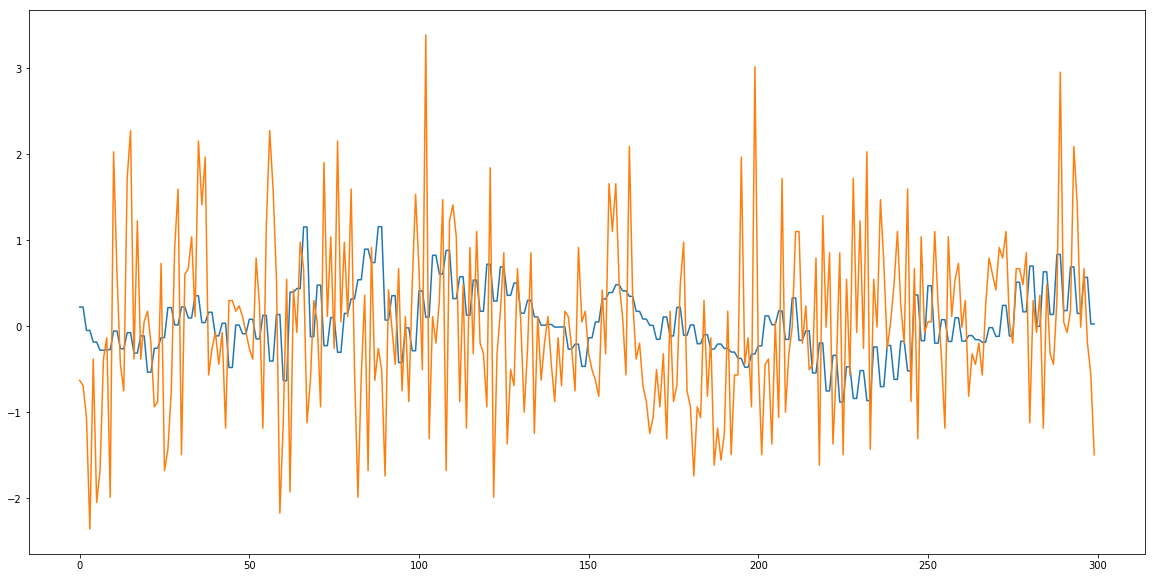

In [4]:
stuff = model.predict(data[np.newaxis, 1000])
plt.figure(figsize=(20, 10))
plt.plot(np.squeeze(stuff))
plt.plot(data[1000])
plt.show()

65
94
7
65
94
7


<function matplotlib.pyplot.show>

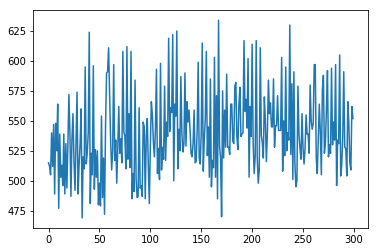

In [31]:
# Extract only slice 7-17 voxels from raw data (also get coordinates)
mask = np.load('/home/chris/projects/rfmri/Data/pig_2/brandon/mask_2017_09_18.npy')
anatomical = nib.load('/home/chris/projects/rfmri/Data/pig_2/coregistered_anatomy.nii').get_data()
raw = np.load("./fmri_preprocessed_2017_09_18.npy") # 16,000 voxels
x,y,z = mask.nonzero()
brandon_x, brandon_y, brandon_z = np.where(mask[:, :, :] == 1)

print(brandon_x[10000])
print(brandon_y[10000])
print(brandon_z[10000])
print(x[10000])
print(y[10000])
print(z[10000])


plt.plot(raw[10000]) #65, 94, 7
plt.show

# slice_mask = ((z >= 7) & (z <= 16))
# len(slice_mask)
# new_x = x[slice_mask]
# new_y = y[slice_mask]
# new_z = z[slice_mask] 
# raw_7_17 = raw[slice_mask] # 12,340

# # Call a new scaler to scale only slice 7-16
# raw_7_17 = np.transpose(raw_7_17)
# scaler = preprocessing.StandardScaler().fit(raw_7_17.astype(float))
# scaled_7_17 = scaler.transform(raw_7_17)
# scaled_7_17 = np.transpose(scaled_7_17)
# scaled_7_17 = np.expand_dims(scaled_7_17, axis=2)

# scaled_7_17.shape




In [40]:
# let's try loading the entire thing to ram
# the big tensor will have dimension [time, height, width, depth]

mean_fmri = nib.load('/home/chris/projects/rfmri/Data/pig_2/rfmri nii/meanus822-0016-00001-000001-01.nii').get_data()  
im = mean_fmri
all_data = np.zeros((300, im.shape[0], im.shape[1], im.shape[2]))
masked_data = np.ma.zeros((300, im.shape[0], im.shape[1], im.shape[2]))

dicom_files = [x for x in Path('/home/chris/projects/rfmri/Data/pig_2/rfmri nii/').iterdir() if x.is_file() and not 'ds_store' in str(x).lower()]
dicom_files.sort(key=str)
time_index = 0

for f in tqdm(dicom_files):
    time_file = nib.load(str(f)).get_data()
    try:
        all_data[time_index, ...] = time_file
        time_index += 1
    except:
        print(f)
        

100%|██████████| 301/301 [00:00<00:00, 531.30it/s]

/home/chris/projects/rfmri/Data/pig_2/rfmri nii/meanus822-0016-00001-000001-01.nii


(300, 128, 128, 20)


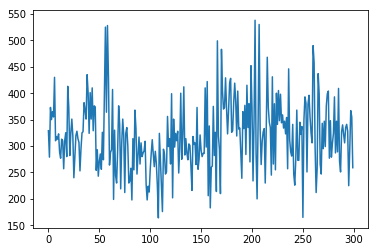

In [45]:
# let's try loading the entire thing to ram
# the big tensor will have dimension [time, height, width, depth]

im = mean_fmri
all_data = np.zeros((300, im.shape[0], im.shape[1], im.shape[2]))
masked_data = np.ma.zeros((300, im.shape[0], im.shape[1], im.shape[2]))

dicom_files = [x for x in Path('../../Data/pig_2/rfmri files/').iterdir() if x.is_file() and not 'ds_store' in str(x).lower()]
dicom_files.sort(key=str)
time_index = 0
mask_roi_1 = np.ma.masked_where(np.isin(realigned_atlas, [0]), realigned_atlas)

for f in tqdm_notebook(dicom_files):
    time_file = nib.load(str(f)).get_data()
    fmri_masked_roi = np.ma.masked_where(np.ma.getmask(mask_roi_1), time_file) 
    try:
        masked_data[time_index, ...] = fmri_masked_roi
        all_data[time_index, ...] = time_file
        time_index += 1
    except:
        print(f)

In [20]:
embedding_model = keras.models.Model(inputs=model.input,
                                 outputs=model.layers[0].output)
model.layers[0].get_config()
embeddings = embedding_model.predict(scaled_7_17) 

In [19]:
embeddings.shape # (12340 voxels, 300 time points, 32 filters)

(12340, 300, 32)

In [23]:
for num_clusters in range(2,4):
    for i in tqdm(range(embeddings.shape[2])): # For each filter...
        filter_embeddings = embeddings[:, :, i]
        gamma = .01

        # Cluster on the filter's embeddings
        clustering = SpectralClustering(n_clusters=num_clusters, gamma=gamma, n_jobs=1).fit_predict(filter_embeddings)
        np.save('./Kernels32_64_128_256_Filters40_10_5_5/Gamma 01/filter_%d_%d_clusters.npy' % (i, num_clusters), clustering)


100%|██████████| 32/32 [11:40<00:00, 22.69s/it]
